In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None,
                     names=['label','file_name','label_text','statement','topic',
                            'speaker','speaker_job','state','party','barely_true_counts',
                            'false_counts','half_true_counts','mostly_true_counts',
                            'pants_on_fire_counts','venue','extracted_context'])
    return df

train_df = load_data('train2.tsv')
val_df = load_data('val2.tsv')
test_df = load_data('test2.tsv')

In [3]:
# There are 2 null values for speaker in the training data. Here we drop them
print("Before: ", train_df['speaker'].isnull().sum())
train_df = train_df.dropna(subset=['speaker'])
print("After: ", train_df['speaker'].isnull().sum())

Before:  2
After:  0


In [4]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def preprocess_data(data):

    data['statement'] = data['statement'].fillna('')  # Fill empty values as string
    data['statement'] = data['statement'].str.lower()  # Convert to lowercase
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove punctuation
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers

    # len(word) > 2 might be unncessary. Let's try
    data['statement'] = data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and len(word) > 2]))  # Remove stopwords

    data['processed_statement'] = data['statement'].apply(lambda x: word_tokenize(x))    # Tokenize

    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    data['processed_statement'] = data['processed_statement'].apply(
        lambda token_list: [lemmatizer.lemmatize(word) for word in token_list])

    return data

train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)
train_df["statement"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,statement
0,says annies list political group supports thir...
1,decline coal start started natural gas took st...
2,hillary clinton agrees john mccain voting give...
3,health care reform legislation likely mandate ...
4,economic turnaround started end term
...,...
10235,larger number shark attacks florida cases vote...
10236,democrats become party atlanta metro area blacks
10237,says alternative social security operates galv...
10238,lifting cuban embargo allowing travel cuba


In [5]:
# Convert processed_statement from list of words to strings
train_texts = train_df['processed_statement'].apply(lambda x: ' '.join(x))
val_texts = val_df['processed_statement'].apply(lambda x: ' '.join(x))
test_texts = test_df['processed_statement'].apply(lambda x: ' '.join(x))

# Encode the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label_text'])
val_labels = label_encoder.transform(val_df['label_text'])
test_labels = label_encoder.transform(test_df['label_text'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences (i.e., list of integers corresponding to words)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad Sequences to Ensure Consistent Length
max_len = 50
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_sequences = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Load GloVe Embeddings
def load_glove_embeddings(glove_path, vocab):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create an embedding matrix
    embedding_matrix = np.zeros((len(vocab) + 1, 100))
    for word, i in vocab.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]

    return embedding_matrix

# Get vocabulary from tokenizer
vocab = tokenizer.word_index

# Load GloVe embeddings (replace with the path to your downloaded GloVe file)
embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', vocab)


In [6]:
# Replicating the model from the paper:
# "Where is your Evidence: Improving Fact-checking by Justification Modeling"

# Define the BiLSTM Model
# Input Layer
statement_input = Input(shape=(max_len,), name='statement_input')

# Embedding Layer with GloVe embeddings
embedding_layer = Embedding(
    input_dim=len(vocab) + 1,  # Add 1 for padding
    output_dim=100,            # GloVe embedding dimension
    weights=[embedding_matrix],  # Set the pre-trained weights
    trainable=False,            # Freeze GloVe embeddings
    name='embedding_layer'
)

# Apply the embedding layer
embedding = embedding_layer(statement_input)

# BiLSTM Layer
bilstm = Bidirectional(LSTM(32), name='bilstm_layer')(embedding)

# Softmax Output Layer
output = Dense(len(label_encoder.classes_), activation='softmax', name='output_layer')(bilstm)

# Compile the Model
model_s = Model(inputs=statement_input, outputs=output)
model_s.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Model summary
model_s.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ statement_input (InputLayer)         │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Embedding)          │ (None, 50, 100)             │       1,073,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer (Bidirectional)         │ (None, 64)                  │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,107,438 (4.22 MB)

 Trainable params: 34,438 (134.52 KB)

 Non-trainable params: 1,073,000 (4.09 MB)

In [7]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
train_labels_one_hot = to_categorical(train_labels, num_classes=len(label_encoder.classes_))
val_labels_one_hot = to_categorical(val_labels, num_classes=len(label_encoder.classes_))
test_labels_one_hot = to_categorical(test_labels, num_classes=len(label_encoder.classes_))

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

lr = 0.001
optimizer = Adam(learning_rate=lr)

# Compile the model
model_s.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Train the Model
history = model_s.fit(train_sequences, train_labels_one_hot,
                      validation_data=(val_sequences, val_labels_one_hot),
                      epochs=10,
                      batch_size=32)


Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2104 - loss: 1.7550 - val_accuracy: 0.2430 - val_loss: 1.7233
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.2441 - loss: 1.7129 - val_accuracy: 0.2547 - val_loss: 1.7104
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.2611 - loss: 1.6963 - val_accuracy: 0.2352 - val_loss: 1.7097
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.2791 - loss: 1.6782 - val_accuracy: 0.2407 - val_loss: 1.7126
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.2995 - loss: 1.6572 - val_accuracy: 0.2445 - val_loss: 1.7182
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.3192 - loss: 1.6333 - val_accuracy: 0.2593 - val_loss: 1.7248
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3379 - loss: 1.6047 - val_accuracy: 0.2430 - val_loss: 1.7354
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.3502 - loss: 1.5755 - 

In [8]:
# Evaluate on Test Data
test_loss, test_accuracy = model_s.evaluate(test_sequences, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}") # %25.17
# The paper performs with %23 accuracy on the test set while our model performs with %24.62

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2342 - loss: 1.8333
Test Loss: 1.7956311702728271
Test Accuracy: 0.24625098705291748


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
F1 Score (Macro): 0.23377689043760305
Macro Precision: 0.23972222105874838
Macro Recall: 0.23930139082474744


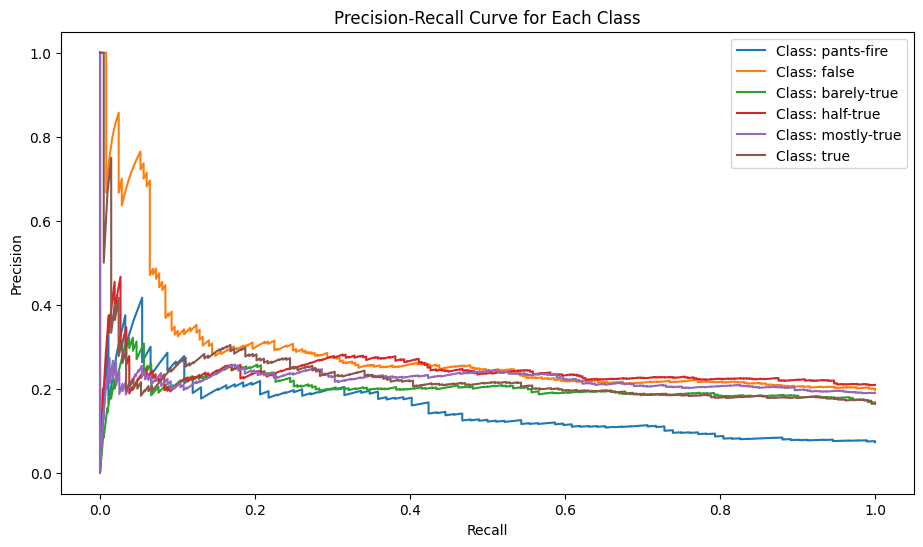

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.13      0.17       212
           1       0.28      0.29      0.29       249
           2       0.26      0.37      0.31       265
           3       0.21      0.16      0.18       241
           4       0.21      0.22      0.21        92
           5       0.23      0.27      0.25       208

    accuracy                           0.25      1267
   macro avg       0.24      0.24      0.23      1267
weighted avg       0.24      0.25      0.24      1267



In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict on the test set
test_preds = model_s.predict(test_sequences)

# Convert predictions from probabilities to class labels
test_preds_classes = np.argmax(test_preds, axis=1)
test_labels_classes = np.argmax(test_labels_one_hot, axis=1)

# F1-Score, Macro Precision, Macro Recall
f1 = f1_score(test_labels_classes, test_preds_classes, average='macro')
macro_precision = precision_score(test_labels_classes, test_preds_classes, average='macro')
macro_recall = recall_score(test_labels_classes, test_preds_classes, average='macro')

# Print the metrics
print(f'F1 Score (Macro): {f1}')
print(f'Macro Precision: {macro_precision}')
print(f'Macro Recall: {macro_recall}')

# Precision-Recall Curve (One-vs-Rest)
class_order = [4, 1, 0, 2, 3, 5]
recall = dict()
thresholds = dict()

plt.figure(figsize=(11, 6))

# Compute Precision-Recall curve for each class
for i in class_order:
    precision[i], recall[i], thresholds[i] = precision_recall_curve(
        test_labels_one_hot[:, i], test_preds[:, i])

    # Plot Precision-Recall Curve for each class
    plt.plot(recall[i], precision[i], linestyle='-', label=f'Class: {label_encoder.classes_[i]}')

# Plot all curves
plt.title('Precision-Recall Curve for Each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Classification Report (Optional)
print("Classification Report:\n", classification_report(test_labels_classes, test_preds_classes))


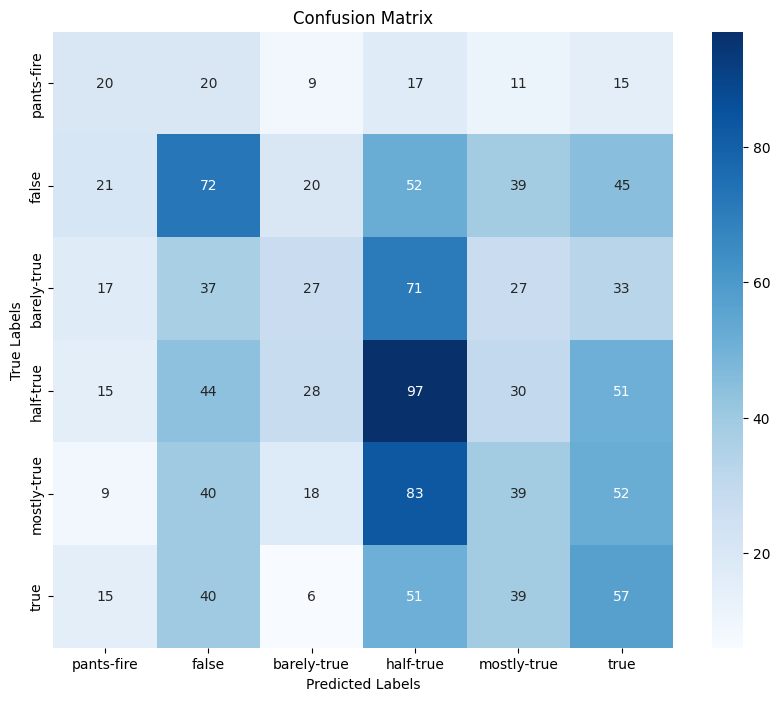

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your custom order of classes and the corresponding class names
custom_class_order = [4, 1, 0, 2, 3, 5]
custom_class_names = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Map the true and predicted labels according to custom order
train_labels_mapped = np.array([custom_class_order.index(label) for label in test_labels])
pred_labels_mapped = np.array([custom_class_order.index(label) for label in np.argmax(test_preds, axis=1)])

# Generate the confusion matrix
cm = confusion_matrix(train_labels_mapped, pred_labels_mapped)

# Create a heatmap with custom class order and class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=custom_class_names, yticklabels=custom_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
# Train a logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=2000, multi_class='ovr')
lr_model.fit(train_sequences, train_labels)

# Make predictions
train_preds = lr_model.predict(train_sequences)
val_preds = lr_model.predict(val_sequences)
test_preds = lr_model.predict(test_sequences)

# Evaluate the model
print(f'Training Accuracy: {accuracy_score(train_labels, train_preds)}') # %21.70
print(f'Validation Accuracy: {accuracy_score(val_labels, val_preds)}') # %19.47
print(f'Test Accuracy: {accuracy_score(test_labels, test_preds)}')  # %19.17

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.21703457706583318
Validation Accuracy: 0.19470404984423675
Test Accuracy: 0.19179163378058406


In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Train the SVM model
svm_model = LinearSVC(random_state=42)
svm_model.fit(train_sequences, train_labels)

# Make predictions
train_preds_svm = svm_model.predict(train_sequences)
val_preds_svm = svm_model.predict(val_sequences)
test_preds_svm = svm_model.predict(test_sequences)

# Evaluate the model
print(f'Training Accuracy (SVM): {accuracy_score(train_labels, train_preds_svm)}') # %20.74
print(f'Validation Accuracy (SVM): {accuracy_score(val_labels, val_preds_svm)}') # %20.56
print(f'Test Accuracy (SVM): {accuracy_score(test_labels, test_preds_svm)}') # %20.20


Training Accuracy (SVM): 0.20746239499902325
Validation Accuracy (SVM): 0.205607476635514
Test Accuracy (SVM): 0.20205209155485399


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Convert lists of words back to strings for TF-IDF Vectorizer
train_texts = [' '.join(words) for words in train_df['processed_statement']]
val_texts = [' '.join(words) for words in val_df['processed_statement']]
test_texts = [' '.join(words) for words in test_df['processed_statement']]

# Bag of Words Vectorization
vectorizer = CountVectorizer(max_features=5000)  # Limit vocabulary size
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)


In [12]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label_text'])
y_val = label_encoder.transform(val_df['label_text'])
y_test = label_encoder.transform(test_df['label_text'])

# Train Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [13]:
# Predictions
train_preds = nb_model.predict(X_train)
val_preds = nb_model.predict(X_val)
test_preds = nb_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(train_labels, train_preds)
val_acc = accuracy_score(val_labels, val_preds)
test_acc = accuracy_score(test_labels, test_preds)

print(f"Training Accuracy (Multinomial NB): {train_acc:.4f}") # %57.14
print(f"Validation Accuracy (Multinomial NB): {val_acc:.4f}") # %24.22
print(f"Test Accuracy (Multinomial NB): {test_acc:.4f}") # %23.99

# Optional: Detailed Classification Report
print("\nClassification Report (Validation Set):")
print(classification_report(val_labels, val_preds))


Training Accuracy (Multinomial NB): 0.5714
Validation Accuracy (Multinomial NB): 0.2422
Test Accuracy (Multinomial NB): 0.2399

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.18      0.15      0.16       237
           1       0.29      0.29      0.29       263
           2       0.23      0.30      0.26       248
           3       0.26      0.29      0.27       251
           4       0.29      0.15      0.20       116
           5       0.21      0.21      0.21       169

    accuracy                           0.24      1284
   macro avg       0.24      0.23      0.23      1284
weighted avg       0.24      0.24      0.24      1284

